In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# 1. Download and Load the Dataset
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# 2. Perform the describe and info steps

#info()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
#describe
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


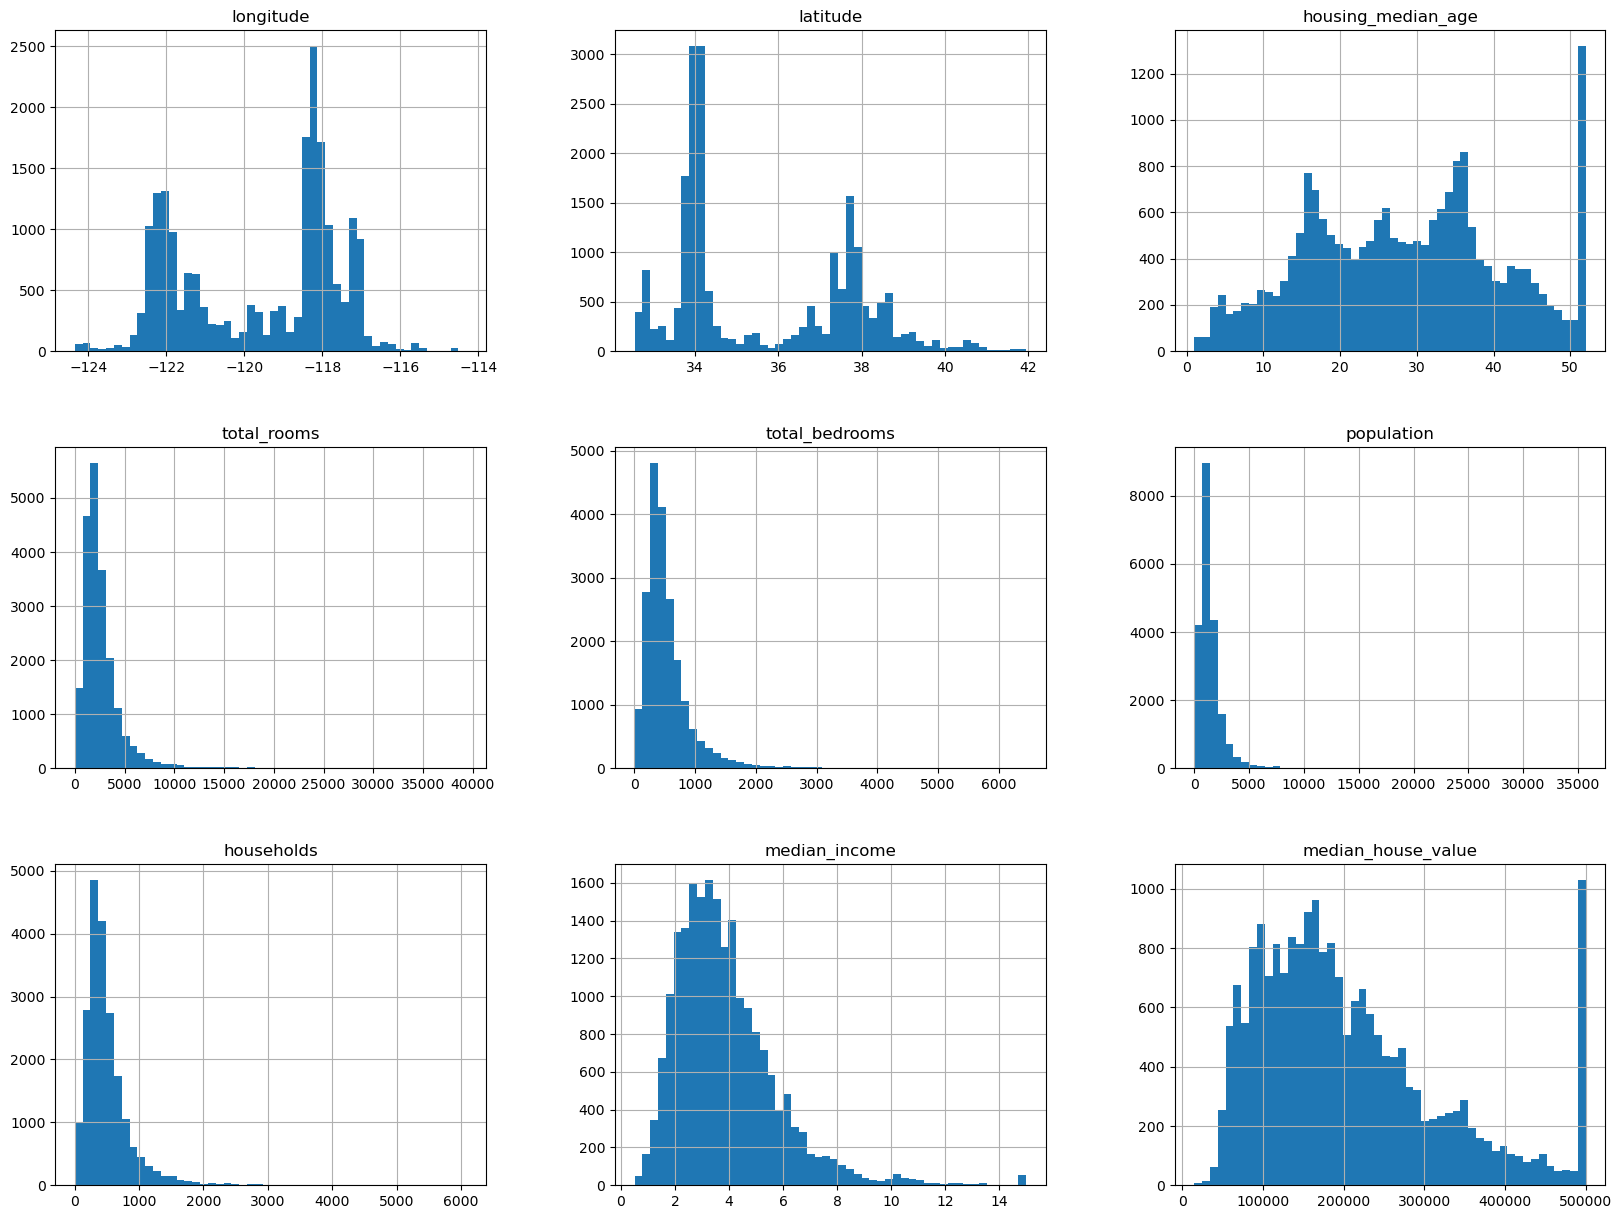

In [5]:
# 3. Plot the histogram of each feature
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [16]:
# 4. Creating a Test Set

# a) Random Train-Test Split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print("Training set size:", len(train_set))
print("Test set size:", len(test_set))

Training set size: 16512
Test set size: 4128


In [20]:
# b) Stratified Sampling (on income)

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0,1.5,3.0,4.5,6,np.inf],
    labels=[1,2,3,4,5]
)
pd.DataFrame(housing["income_cat"])

,income_cat
0,5
1,5
2,5
3,4
4,3
...,...
20635,2
20636,2
20637,2
20638,2


In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]
print("Stratified training set size:", len(strat_train))
print("Stratified test set size:", len(strat_test))

Stratified training set size: 16512
Stratified test set size: 4128


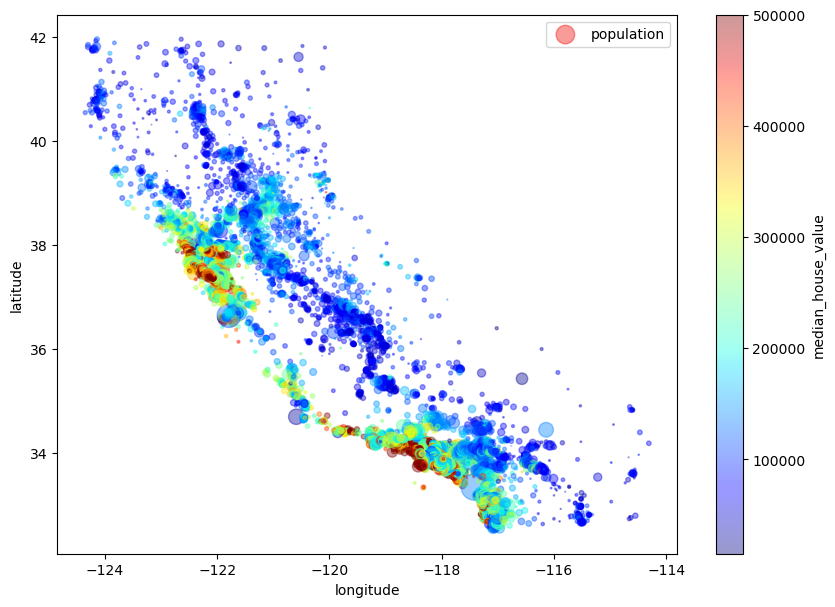

In [21]:
# 4. Geographical Features & Visualization
housing.plot(kind="scatter", x="longitude", y="latitude",
             alpha=0.4,
             s=housing["population"]/100,
             label="population",
             figsize=(10,7),
             c="median_house_value",
             cmap=plt.get_cmap("jet"),
             colorbar=True)
plt.legend()
plt.show()

'''Interpretation:
High prices near coastal areas
Dense population → higher prices
Strong location dependency'''

In [22]:
# 5. Correlation with Housing Price
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

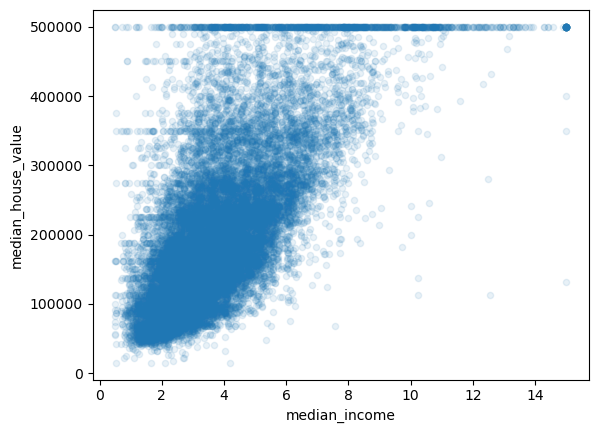

In [23]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

'''Interpretation:
Strong positive linear trend
Income is the best predictor'''

In [27]:
# 6. Feature Combination to Improve Correlation

housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

housing.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [29]:
# 7. Data Cleaning

# Missing Values
housing["total_bedrooms"].isnull().sum()

207

In [34]:
# Cleaning using Median
median = housing["total_bedrooms"].median()
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)
housing["total_bedrooms"].isnull().sum()

0

In [57]:
# 8. Is there any categorical data that needs to be converted to numerical? If so explain the 
# method used to convert and code the same and show the output.

# select categorical columns
cat_cols = housing.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = ohe.fit_transform(housing[cat_cols])
encoded_cols = ohe.get_feature_names_out(cat_cols)
encoded_housing = pd.DataFrame(
    encoded_array,
    columns=encoded_cols,
    index=housing.index
)
housing_ohe = pd.concat(
    [housing.drop(cat_cols, axis=1), encoded_housing],
    axis=1
)
housing_ohe
#Why One-Hot?
#No ordinal relationship
#Prevents misleading numeric ordering

Categorical columns: Index(['ocean_proximity'], dtype='object')


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1.0,0.0,0.0,0.0


In [44]:
''' 9. Feature Scaling – Why Important?
Importance

Prevents dominance of large-scale features

Required for Gradient Descent & Distance models

Improves convergence speed '''

' 9. Feature Scaling – Why Important?\nImportance\n\nPrevents dominance of large-scale features\n\nRequired for Gradient Descent & Distance models\n\nImproves convergence speed '

In [62]:
# 10. Complete Pipeline (Custom + Scaling + Encoding)

# Custom Transformer
class AttrAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.c_[X,
                     X["total_rooms"]/X["households"],
                     X["population"]/X["households"],
                     X["total_bedrooms"]/X["total_rooms"]]

# Features
X = housing.drop("median_house_value", axis=1)

num_cols = X.drop("ocean_proximity", axis=1).columns
cat_cols = ["ocean_proximity"]

# Pipeline
pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("add", AttrAdder()),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", OneHotEncoder(sparse_output=False), cat_cols)
])

# Apply
X_prepared = pipeline.fit_transform(X)
X_prepared.shape


(20640, 16)